In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import json

In [2]:
orders = pd.read_csv('orders.csv')
sales = pd.read_csv('sales.csv')
user = pd.read_csv('user.csv')
store = pd.read_csv('store.csv')
product = pd.read_csv('product.csv')

In [3]:
# В данных столбец orders['product_info'] представлен в некорректном формате. Формат JSON предполагает, что строка
# заключена в двойные кавычки, а не одинарные, а также, True и False должны быть написаны с маленькой буквы
# иначе мы просто не сможем корректно считать json-строку. Исправим это:
orders['product_info'] = orders['product_info'].replace('\'', '"', regex=True).replace('True', 'true', regex=True).replace('False', 'false', regex=True)
orders['product_info'] = orders['product_info'].apply(json.loads)
new_ord = orders.explode('product_info')
new_ord = new_ord.reset_index(drop=True)
orders = pd.concat([new_ord, pd.DataFrame(new_ord['product_info'].tolist())], axis=1)
del new_ord
del orders['product_info']
del sales['id']

In [4]:
orders = pd.merge(orders, sales[['order_id', 'product_id', 'is_canceled', 'is_accepted']], on=['order_id', 'product_id'])
orders = orders[((orders['is_canceled'] == False) & (orders['is_accepted'] == True)) | (orders['is_canceled'] == False) & (orders['is_accepted'] == False)]
orders['order_date'] = pd.to_datetime(orders['order_date'])

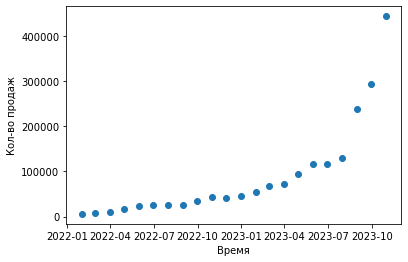

In [5]:
mth = orders.set_index('order_date', inplace=True)
mth = orders['count'].resample('M').sum()
del mth['2023-11-30']
# Будем предполагать, что распределение товаров по магазинам не зависит от времени или по крайней мере за месяц меняется
# незначительно
#Воспользуемся моделью линейной регрессии. Изобразим зависимость общего количества продаж от вермени
x = mth.index.tolist()
y = mth.values.tolist()
plt.xlabel('Время')
plt.ylabel('Кол-во продаж')
plt.plot(x, y, 'o')
plt.show()

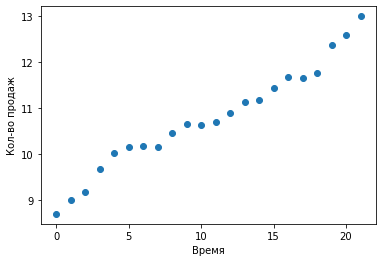

In [6]:
#Как видим, зависимость от времени мало похожа на линейную. Попробуем прологарифмировать количество продаж
y = np.log(y)
plt.xlabel('Время')
plt.ylabel('Кол-во продаж')
x = np.arange(len(x))
plt.plot(x, y, 'o')
plt.show()


In [7]:
# Как видим, действительно количество продаж растёт экспоненциально, так как после
# логарифмирования мы наблюдаем линейный график
# Воспользуемся теперь моделью линейной регрессии с одним предиктором
model = LinearRegression()
results = model.fit(np.arange(len(x)).reshape(-1, 1), y)
#Предскажем значение продаж
x_new = np.array([22, 23, 24]).reshape(-1, 1)
y_pred = model.predict(x_new)
print(f'''Прогноз роста продаж на следующие 3 месяца: {int(round(np.exp(y_pred)[0], -3))}, 
{int(round(np.exp(y_pred)[1], -3))}, {int(round(np.exp(y_pred)[2], -3))}''')

Прогноз роста продаж на следующие 3 месяца: 350000, 
416000, 494000


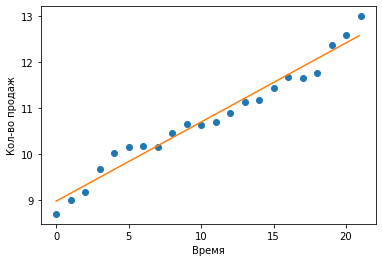

In [8]:
plt.xlabel('Время')
plt.ylabel('Кол-во продаж')
x = np.arange(len(x))
plt.plot(x, y, 'o')
x1 = np.arange(0, 21, 0.1)
plt.plot(x1, model.intercept_ + x1 * model.coef_)
plt.show()

In [9]:
# Прогноз продаж в следующем месяце с учётом предположения о том что распределение количество покупаемых товаров
# по магазинам не зависит от времени
next_month = int(round(np.exp(y_pred)[0], -3))
orders = pd.merge(orders, store, on='store_id')
sales_by_shop = orders.groupby(['product_id', 'store_name'])['count'].sum().reset_index()
all_count = orders['count'].sum()
sales_by_shop['next_month_expec'] = round(sales_by_shop['count'] / all_count * next_month)
sales_by_shop = sales_by_shop[['store_name', 'product_id', 'next_month_expec']].sort_values(['store_name', 'product_id']).reset_index(drop=True)
# В датафреймме sales_by_shop лежит ожидаемое значение всех товаров во всех магазинах которое должно находится на складе
# на следующий месяц

In [10]:
sales_by_shop

,store_name,product_id,next_month_expec
0,Afimoll,1,3.0
1,Afimoll,2,2.0
2,Afimoll,3,2.0
3,Afimoll,4,3.0
4,Afimoll,5,4.0
...,...,...,...
54483,Tsvetnoy,3716,2.0
54484,Tsvetnoy,3717,2.0
54485,Tsvetnoy,3718,2.0
54486,Tsvetnoy,3719,2.0
